https://arxiv.org/pdf/1610.02357.pdf

### Xception

#### (depthwise) separable convolution

図に示すようにinputに対し1×1の畳み込み層でチャンネル数をoutput channelsに増やし、
そのチャンネルを重複のないセグメントに分けそれぞれ3×3の畳み込みを行い、
最後に各出力を結合します。
これを(depthwise) separable convolutionと呼びます。本来の「separable convolution」は3×3の畳み込みのあとに1×1の畳み込みを行いますが、層を積み重ねていくのでその違いは重要でないと考えます。
Xceptionでは1チャンネルごとに3×3の畳み込みを行います。

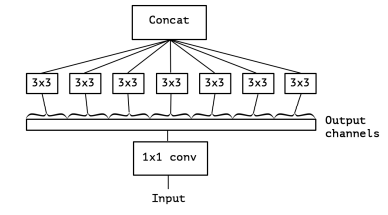

プーリング層のないシンプルなInception(上図)を考えたときに、このseparable convolutionで表現できる(下図)ことが分かります。

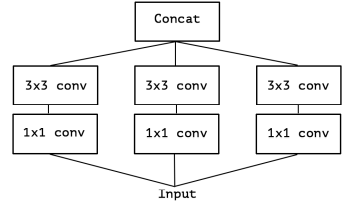

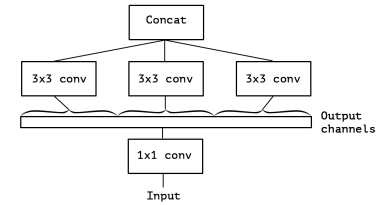


構造の詳細を見ます。  
residual接続を含みますが、separable convolutionの積み重ねとなっています。   
すべてのConv層のあとにはBatchNormalizationが含まれます。

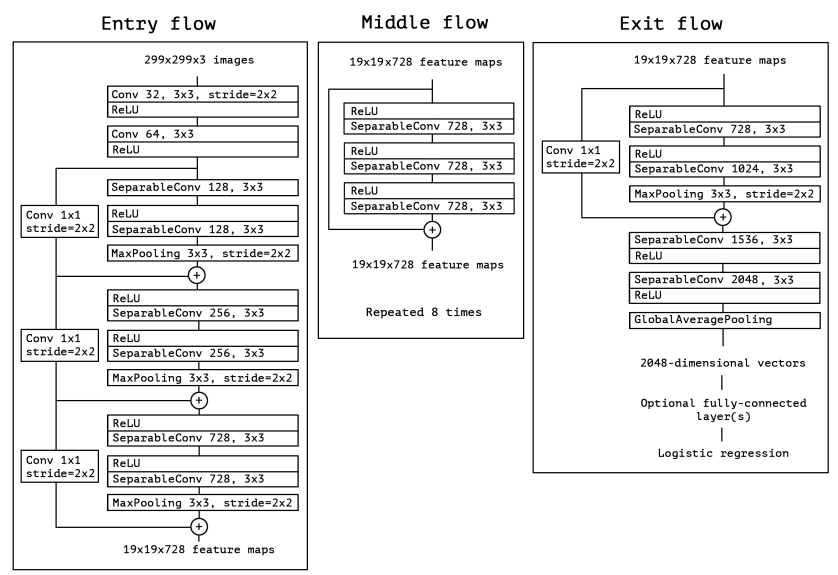

InceptionV1~3であったような途中の層で分類させるような構造は持ちません。

#### 学習
SGDでmomentumを0.9とします。
学習率は初期値が0.045で2エポックごとに0.94をかけて小さくしていきます。

In [255]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add, SeparableConv2D
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import math
import cv2

In [216]:
class conv_relu_bn(Model):
    def __init__(self, out_channels, act=True, inv=False):
        super().__init__()
        self.act = act
        self.inv = inv
    
        if act:
            self.relu = Activation("relu")
        self.conv = SeparableConv2D(out_channels, kernel_size=3, padding='same')
        self.bn = BatchNormalization()
    
    def call(self, x):
        if self.inv:
            if self.act:
                x = self.relu(x)
            x = self.conv(x)
            x = self.bn(x)
        else:
            x = self.conv(x)
            x = self.bn(x)
            if self.act:
                x = self.relu(x)
        return x

In [217]:
class exception_block(Model):
    def __init__(self, out_channels1, out_channels2=None, act=True, pool=True):
        super().__init__()
        if not out_channels2:
            out_channels2 = out_channels1
        
        self.conv1 = conv_relu_bn(out_channels1, act=act)
        self.conv2 = conv_relu_bn(out_channels2)
        if pool:
            self.layer3 = MaxPooling2D(pool_size=3, strides=2, padding='same')
        else:
            self.layer3 = conv_relu_bn(out_channels2)
            
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.layer3(x)
        return x

In [218]:
class Ently_flow(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same')
        self.relu1 = Activation("relu")
        
        self.conv2 = Conv2D(64, kernel_size=3, padding='same')
        self.relu2 = Activation("relu")
        
        self.block1 = exception_block(out_channels1=128, act=False)
        self.block2 = exception_block(out_channels1=256)
        self.block3 = exception_block(out_channels1=728)

        self.res1 = Conv2D(128, kernel_size=1, strides=2, padding='same')
        self.res2 = Conv2D(256, kernel_size=1, strides=2, padding='same')
        self.res3 = Conv2D(728, kernel_size=1, strides=2, padding='same')
        
        self.add1 = Add()
        self.add2 = Add()
        self.add3 = Add()
        
    def call(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        res1 = self.res1(x)
        res2 = self.res2(res1)
        res3 = self.res3(res2)
        
        out1 = self.block1(x)
        out1 = self.add1([out1, res1])
        out2 = self.block2(out1)
        out2 = self.add2([out2, res2])
        out3 = self.block3(out2)
        out3 = self.add3([out3, res3])
        
        return out3

In [219]:
class Middle_block(Model):
    def __init__(self):
        super().__init__()
        self.block = exception_block(out_channels1=728, pool=False)
        self.add = Add()
        
    def call(self, x):
        res = x
        out = self.block(x)
        out = self.add([out, res])
        
        return out

In [220]:
class Middle_flow(Model):
    def __init__(self):
        super().__init__()
        self.except_layers = [Middle_block() for _ in range(8)]
        
    def call(self, x):
        for layer in self.except_layers:
            x = layer(x)
        
        return x

In [221]:
class Exit_flow(Model):
    def __init__(self):
        super().__init__()
        
        self.block = exception_block(out_channels1=728, out_channels2=1024, pool=True)
        
        self.res = Conv2D(1024, kernel_size=1, strides=2, padding='same')
        self.add = Add()
        
        self.conv1 = conv_relu_bn(out_channels=1536, inv=True)
        self.conv2 = conv_relu_bn(out_channels=2048, inv=True)
        
        self.pool = GlobalAveragePooling2D()
        
        self.fc1 = Dense(1024)
        self.fc2 = Dense(512)
        self.fc3 = Dense(10, activation = 'softmax')
    
    def call(self, x):
        res = x
        res = self.res(res)
        
        x = self.block(x)
        x = self.add([x, res])
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [222]:
class Xception(Model):
    def __init__(self):
        super().__init__()
        self.entry = Ently_flow()
        self.middle = Middle_flow()
        self.exit = Exit_flow()
        
    def call(self, x):
        x = self.entry(x)
        x = self.middle(x)
        x = self.exit(x)
        return x

In [223]:
model = Xception()
model.build((None, 299, 299, 3))  # build with input shape.
dummy_input = Input(shape=(299, 299, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
ently_flow_29 (Ently_flow)   (None, 19, 19, 728)       1112224   
_________________________________________________________________
middle_flow_20 (Middle_flow) (None, 19, 19, 728)       12964224  
_________________________________________________________________
exit_flow_18 (Exit_flow)     (None, 10)                7851442   
Total params: 21,927,890
Trainable params: 21,878,850
Non-trainable params: 49,040
_________________________________________________________________


In [ ]:
epochs = 100
initial_lrate = 0.0045

def decay(epoch, steps=100):
    initial_lrate = 0.0045
    drop = 0.94
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=0.0045, momentum=0.9, decay=1e-4)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = MobileNetV1()
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [229]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.pointwise = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [230]:
class conv_relu_bn(nn.Module):
    def __init__(self, in_channels, out_channels, act=True, inv=False):
        super().__init__()
        self.act = act
        self.inv = inv
        
        if act:
            self.relu = nn.ReLU(True)
        self.conv = SeparableConv2d(in_channels, out_channels)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        if self.inv:
            if self.act:
                x = self.relu(x)
            x = self.conv(x)
            x = self.bn(x)
        else:
            x = self.conv(x)
            x = self.bn(x)
            if self.act:
                x = self.relu(x)
        return x

In [239]:
class exception_block(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2=None, act=True, pool=True):
        super().__init__()
        if not out_channels2:
            out_channels2 = out_channels1
        
        self.conv1 = conv_relu_bn(in_channels=in_channels, out_channels=out_channels1, act=act)
        self.conv2 = conv_relu_bn(in_channels=out_channels1, out_channels=out_channels2)
        if pool:
            self.layer3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.layer3 = conv_relu_bn(in_channels=out_channels2, out_channels=out_channels2)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.layer3(x)
        return x

In [240]:
class Ently_flow(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(True)
        
        self.block1 = exception_block(in_channels=64, out_channels1=128, act=False)
        self.block2 = exception_block(in_channels=128, out_channels1=256)
        self.block3 = exception_block(in_channels=256, out_channels1=728)

        self.res1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, padding=0)
        self.res2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, padding=0)
        self.res3 = nn.Conv2d(in_channels=256, out_channels=728, kernel_size=1, stride=2, padding=0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        res1 = self.res1(x)
        res2 = self.res2(res1)
        res3 = self.res3(res2)
        
        out1 = self.block1(x)
        out1 = out1 + res1
        out2 = self.block2(out1)
        out2 = out2 + res2
        out3 = self.block3(out2)
        out3 = out3 + res3
        
        return out3

In [241]:
class Middle_block(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = exception_block(in_channels=728, out_channels1=728, pool=False)
        
    def forward(self, x):
        res = x
        out = self.block(x)
        out = out + res
        
        return out

In [242]:
class Middle_flow(nn.Module):
    def __init__(self):
        super().__init__()
        self.except_layers = nn.Sequential(*[Middle_block() for _ in range(8)])
        
    def forward(self, x):
        for layer in self.except_layers:
            x = layer(x)
        
        return x

In [251]:
class Exit_flow(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block = exception_block(in_channels=728, out_channels1=728, out_channels2=1024, pool=True)
        
        self.res = nn.Conv2d(in_channels=728, out_channels=1024, kernel_size=1, stride=2, padding=0)
        
        self.conv1 = conv_relu_bn(in_channels=1024, out_channels=1536, inv=True)
        self.conv2 = conv_relu_bn(in_channels=1536, out_channels=2048, inv=True)
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    
    def forward(self, x):
        res = x
        res = self.res(res)
        
        x = self.block(x)
        x = x + res
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [253]:
class Xception(nn.Module):
    def __init__(self):
        super().__init__()
        self.entry = Ently_flow()
        self.middle = Middle_flow()
        self.exit = Exit_flow()
        
    def forward(self, x):
        x = self.entry(x)
        x = self.middle(x)
        x = self.exit(x)
        return x

In [254]:
from torchsummary import summary


summary(Xception(), (3,299,299))

torch.Size([2, 728, 19, 19])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          18,496
              ReLU-4         [-1, 64, 150, 150]               0
            Conv2d-5          [-1, 128, 75, 75]           8,320
            Conv2d-6          [-1, 256, 38, 38]          33,024
            Conv2d-7          [-1, 728, 19, 19]         187,096
            Conv2d-8        [-1, 128, 150, 150]          73,856
            Conv2d-9        [-1, 128, 150, 150]          16,512
  SeparableConv2d-10        [-1, 128, 150, 150]               0
      BatchNorm2d-11        [-1, 128, 150, 150]             256
     conv_relu_bn-12        [-1, 128, 150, 150]               0
           Conv2d-13        [-1, 128, 150, 150]         147,584
          

     BatchNorm2d-125          [-1, 728, 19, 19]           1,456
            ReLU-126          [-1, 728, 19, 19]               0
    conv_relu_bn-127          [-1, 728, 19, 19]               0
 exception_block-128          [-1, 728, 19, 19]               0
    Middle_block-129          [-1, 728, 19, 19]               0
          Conv2d-130          [-1, 728, 19, 19]       4,770,584
          Conv2d-131          [-1, 728, 19, 19]         530,712
 SeparableConv2d-132          [-1, 728, 19, 19]               0
     BatchNorm2d-133          [-1, 728, 19, 19]           1,456
            ReLU-134          [-1, 728, 19, 19]               0
    conv_relu_bn-135          [-1, 728, 19, 19]               0
          Conv2d-136          [-1, 728, 19, 19]       4,770,584
          Conv2d-137          [-1, 728, 19, 19]         530,712
 SeparableConv2d-138          [-1, 728, 19, 19]               0
     BatchNorm2d-139          [-1, 728, 19, 19]           1,456
            ReLU-140          [-1, 728, 

In [ ]:
class XceptionTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = Xception()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.045, eps=1.0, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.94)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}